In [1]:
import keras
import time
import numpy as np
import tensorflow as tf
import os
from collections import deque
import matplotlib.pyplot as plt
from pacman import *
from keras import layers, models

pygame 2.5.2 (SDL 2.28.3, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class DQN:
    def __init__(
        self,
        grid_size: tuple[int, int],
        grid_depth: int,
        discount_factor: float,
        folder: str,
        replay_memory_length=50000,
    ) -> None:
        self.grid_size = grid_size
        self.grid_depth = grid_depth
        self.y = discount_factor
        self.folder = folder
        self.q_network = self._create_model()
        self.target_network = self._create_model()
        try:
            self.q_network.load_weights(os.path.join(self.folder, "weights.keras"))
            print("Loaded weights")
        except Exception as e:
            print(f"Can't load weights: {e}")
        finally:
            self.update_target_model()
            self.replay_memory = deque(maxlen=replay_memory_length)

    def _create_model(self):
        model = models.Sequential(
            [
                layers.InputLayer(
                    input_shape=(self.grid_size[0], self.grid_size[1], self.grid_depth)
                ),
                layers.Conv2D(32, (3, 3), activation="relu"),
                layers.Flatten(),
                layers.Dense(256, activation="relu"),
                layers.Dense(128, activation="relu"),
                layers.Dense(4, activation="linear"),
            ]
        )
        model.compile(optimizer=keras.optimizers.Adam(), loss="mse")
        return model

    def _create_batch(self, batch_size=128, to_zip=True):
        batch = random.sample(self.replay_memory, batch_size)
        if to_zip:
            (
                states,
                actions,
                rewards,
                next_states,
                terminals,
                pacman_locations,
                next_pacman_locations,
            ) = zip(*batch)

            states = np.array(states)
            actions = np.array(actions)
            rewards = np.array(rewards)
            next_states = np.array(next_states)
            terminals = np.array(terminals)

            return (
                states,
                actions,
                rewards,
                next_states,
                terminals,
                pacman_locations,
                next_pacman_locations,
            )
        return batch

    def _format_state(self, state, pacman_location):
        """tiny_state = get_tiny_obs(state, pacman_location, r=2)
        return tf.one_hot(tiny_state, self.grid_depth)"""
        return tf.one_hot(state, self.grid_depth)

    def _format_states(self, states, pacman_locations):
        """tiny_states = [
            get_tiny_obs(state, pacman_location, r=2)
            for state, pacman_location in zip(states, pacman_locations)
        ]
        return tf.one_hot(tiny_states, self.grid_depth)"""
        return tf.one_hot(states, self.grid_depth)

    def update_target_model(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def predict_action(self, env: PacmanEnv, obs, epsilon=0):
        if random.random() > epsilon:  # exploit
            state = self._format_state(obs, env.pacman.location())
            x = np.expand_dims(state, 0)
            q_values = self.q_network(x)[0]
            return env.best_action(q_values)
        # explore
        return get_next_move(obs, env.pacman.location())
        # return env.random_action()

    def add_data(
        self,
        state,
        action,
        reward,
        next_state,
        terminal,
        pacman_location,
        next_pacman_location,
    ):
        self.replay_memory.append(
            (
                state,
                action,
                reward,
                next_state,
                int(terminal),
                pacman_location,
                next_pacman_location,
            )
        )

    def save_data(self):
        self.q_network.save_weights(os.path.join(self.folder, "weights.keras"))

    def create_training_data(
        self,
        states,
        actions,
        rewards,
        next_states,
        terminals,
        pacman_locations,
        next_pacman_locations,
    ):
        one_hot_states = self._format_states(states, pacman_locations)
        one_hot_next_states = self._format_states(next_states, next_pacman_locations)
        target_preds = self.max_valid(
            states,
            self.target_network.predict(one_hot_next_states, verbose=0),
            pacman_locations,
        )
        target_values = rewards + self.y * target_preds * (1 - terminals)

        q_values = self.q_network.predict(one_hot_states, verbose=0)
        q_values[np.arange(len(q_values)), actions] = target_values
        return one_hot_states, q_values

    def train_on_batch(self, batch_size):
        x, y = self.create_training_data(*self._create_batch(batch_size))
        with tf.GradientTape() as tape:
            # Forward pass
            q_values = self.q_network(x, training=True)
            # Compute loss
            loss = tf.reduce_mean(tf.square(y - q_values))

        # Get gradients
        gradients = tape.gradient(loss, self.q_network.trainable_variables)

        # Apply gradients
        self.q_network.optimizer.apply_gradients(
            zip(gradients, self.q_network.trainable_variables)
        )
        return loss

    def max_valid(self, states, q_values_list, pacman_locations):
        max_values = []
        for state, q_values, pacman_location in zip(
            states, q_values_list, pacman_locations
        ):
            valid_actions = []

            if (
                pacman_location[1] == 0
                or state[pacman_location[1] - 1][pacman_location[0]] != 1
            ):
                valid_actions.append(0)  # Up
            if (
                pacman_location[1] == len(state) - 1
                or state[pacman_location[1] + 1][pacman_location[0]] != 1
            ):
                valid_actions.append(1)  # Down
            if (
                pacman_location[0] == 0
                or state[pacman_location[1]][pacman_location[0] - 1] != 1
            ):
                valid_actions.append(2)  # Left
            if (
                pacman_location[0] == len(state[0]) - 1
                or state[pacman_location[1]][pacman_location[0] + 1] != 1
            ):
                valid_actions.append(3)  # Right

            if not valid_actions:
                return None

            best_action_index = valid_actions[0]
            for i in valid_actions[1:]:
                if q_values[i] > q_values[best_action_index]:
                    best_action_index = i
            max_values.append(q_values[best_action_index])
        return np.array(max_values)

In [3]:
def time_until_done(start_time, episode, num_episodes):
    current_time = time.time()
    elapsed_time = current_time - start_time

    average_time_per_episode = elapsed_time / episode
    remaining_episodes = num_episodes - episode
    estimated_remaining_time = remaining_episodes * average_time_per_episode

    # Calculate days, hours, minutes, and seconds
    days, remainder = divmod(estimated_remaining_time, 86400)
    hours, remainder = divmod(remainder, 3600)
    minutes, seconds = divmod(remainder, 60)

    return f"{int(days)} days, {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds"

In [4]:
GRID_SIZE = (31, 28)
GRID_SIZE = (16, 21)
GRID_SIZE = (11, 20)
# GRID_SIZE = (5, 5)
# GRID_SIZE = (6, 6)
X = True
Y = False

In [5]:
def remove_strips(grid, strips: list[tuple[int, int, bool, int]]):
    grid = [[tile for tile in row] for row in grid]
    for start, end, axis, pos in strips:
        if axis is X:
            for x in range(start, end + 1):
                grid[pos][x] = 0
        elif axis is Y:
            for y in range(start, end + 1):
                grid[y][pos] = 0
    return grid

In [6]:
grid = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 2, 2, 2, 2, 2, 2, 2, 0, 1],
    [1, 0, 1, 1, 1, 2, 1, 1, 2, 1],
    [1, 2, 1, 2, 2, 2, 2, 1, 2, 1],
    [1, 2, 2, 2, 1, 1, 2, 1, 2, 1],
    [1, 2, 1, 2, 2, 2, 2, 1, 2, 1],
    [1, 2, 1, 1, 1, 1, 0, 2, 2, 1],
    [1, 0, 2, 2, 2, 1, 2, 1, 2, 1],
    [1, 1, 2, 1, 2, 2, 2, 2, 2, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
]
grid = generate_grid((4, 4))
print(grid)

grid = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1],
        [1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1],
        [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1],
        [1, 0, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 0, 1],
        [1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1],
        [1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1],
        [1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1],
        [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1],
        [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1],
        [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

grid = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1],
        [1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1],
        [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
        [1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1],
        [0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0],
        [1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1],
        [1, 1, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 1, 1],
        [1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1],
        [0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0],
        [1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1],
        [1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1],
        [1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1],
        [1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1],
        [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

grid = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1],
        [1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1],
        [1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1],
        [1, 2, 1, 2, 1, 1, 2, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2, 1, 2, 1],
        [1, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 1],
        [1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1],
        [1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1],
        [1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1],
        [1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

strips = [
    (1, 12, X, 1),
    (15, 26, X, 1),
    (1, 26, X, 5),
    (1, 6, X, 8),
    (9, 12, X, 8),
    (15, 18, X, 8),
    (21, 26, X, 8),
    (1, 12, X, 20),
    (15, 26, X, 20),
    (1, 3, X, 23),
    (6, 21, X, 23),
    (24, 26, X, 23),
    (1, 6, X, 26),
    (9, 12, X, 26),
    (15, 18, X, 26),
    (21, 26, X, 26),
    (1, 26, X, 29),
    (1, 8, Y, 1),
    (20, 23, Y, 1),
    (26, 29, Y, 1),
    (1, 26, Y, 6),
    (5, 8, Y, 9),
    (23, 26, Y, 9),
    (1, 5, Y, 12),
    (20, 23, Y, 12),
    (26, 29, Y, 12),
    (1, 5, Y, 15),
    (20, 23, Y, 15),
    (26, 29, Y, 15),
    (5, 8, Y, 18),
    (23, 26, Y, 18),
    (1, 26, Y, 21),
    (1, 8, Y, 26),
    (20, 23, Y, 26),
    (26, 29, Y, 26)
]
strips = [
    (1, 4, X, 1),
    (6, 14, X, 1),
    (16, 19, X, 1),
    (1, 19, X, 3),
    (1, 2, X, 5),
    (4, 16, X, 5),
    (18, 19, X, 5),
    (2, 7, X, 7),
    (13, 18, X, 7),
    (1, 2, X, 9),
    (4, 16, X, 9),
    (18, 19, X, 9),
    (1, 4, X, 11),
    (8, 12, X, 11),
    (16, 19, X, 11),
    (6, 8, X, 12),
    (12, 15, X, 12),
    (1, 19, X, 14),
    (1, 3, Y, 1),
    (11, 14, Y, 1),
    (3, 11, Y, 2),
    (1, 5, Y, 4),
    (9, 14, Y, 4),
    (1, 3, Y, 6),
    (9, 12, Y, 6),
    (3, 9, Y, 7),
    (1, 3, Y, 14),
    (9, 12, Y, 14),
    (1, 5, Y, 16),
    (9, 14, Y, 16),
    (3, 11, Y, 18),
    (1, 3, Y, 19),
    (11, 14, Y, 19)
]
strips = [
    (1, 4, X, 1),
    (6, 13, X, 1),
    (15, 18, X, 1),
    (3, 16, X, 3),
    (1, 6, X, 5),
    (13, 18, X, 5),
    (3, 16, X, 7),
    (1, 4, X, 9),
    (6, 13, X, 9),
    (15, 18, X, 9),
    (1, 9, Y, 1),
    (3, 7, Y, 3),
    (1, 3, Y, 4),
    (7, 9, Y, 4),
    (1, 9, Y, 6),
    (1, 9, Y, 13),
    (1, 3, Y, 15),
    (7, 9, Y, 15),
    (3, 7, Y, 16),
    (1, 9, Y, 18)
]

[[1, 1, 1, 1, 1, 1], [1, 2, 2, 1, 2, 1], [1, 1, 2, 2, 2, 1], [1, 1, 2, 2, 2, 1], [1, 1, 2, 2, 2, 1], [1, 1, 1, 1, 1, 1]]


In [7]:
num_episodes = 10000
target_update_frequency = 100
train_after_actions = 5
max_steps_per_episode = 100
y = 0.99  # discount factor
initial_epsilon = 1.0
final_epsilon = 0.0
batch_size = 32

epsilon_decay_rate = (initial_epsilon - final_epsilon) / num_episodes
epsilon = initial_epsilon
win_rate_check = max(num_episodes // 100, 1)

ghost = Ghost(r".\assets\blinky.png", r".\assets\scared_ghost.png", (9, 5), 6)
env = PacmanEnv(
    grid,
    pacman_sprite=r".\assets\pacman.png",
    render_mode="human",
    fps=-1,
    ghosts=[ghost],
    tile_size=20,
)  # Create the environment
reward_history = ([], [])
loss_history = ([], [])

Loaded weights


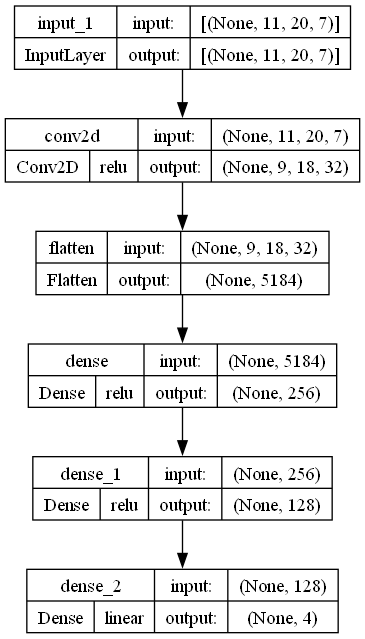

In [8]:
agent = DQN(GRID_SIZE, 7, y, r".\pacman_agent", 100000)
keras.utils.plot_model(agent.q_network, show_shapes=True, show_layer_activations=True)

In [9]:
steps = 0
loss_sum = 0
total_reward = 0
epoch_steps = 0
start_time = time.time()

for episode in range(1, num_episodes + 1):
    if strips:
        if not 0 < epoch_steps < 100:
            num_samples = random.randint(0, len(strips) - 1)
            epoch_steps = 0
        current_strips = random.sample(strips, num_samples)
        obs = env.reset(grid=remove_strips(grid, current_strips), ghosts=[ghost])
    else:
        obs = env.reset(ghosts=[ghost])
    for _ in range(1, max_steps_per_episode + 1):
        action = agent.predict_action(env, obs, epsilon)
        if action is None:  # :)
            break
        next_obs, reward, done, pacman_location, next_pacman_location, closed = (
            env.step(action, debug=False)
        )
        total_reward += reward

        agent.add_data(
            obs, action, reward, next_obs, done, pacman_location, next_pacman_location
        )
        if len(agent.replay_memory) >= batch_size and steps % train_after_actions == 0:
            loss = agent.train_on_batch(batch_size)
            loss_sum += loss

        obs = next_obs
        steps += 1
        epoch_steps += 1
        if steps % target_update_frequency == 0:
            agent.update_target_model()
        if done or closed:
            break

    # Update epsilon for the next episode
    epsilon -= epsilon_decay_rate
    epsilon = max(
        final_epsilon, epsilon
    )  # Ensure epsilon doesn't go below the final value
    if episode % win_rate_check == 0:
        average_reward = total_reward / win_rate_check
        average_loss = loss_sum / win_rate_check
        print(
            f"Episods done: {episode}, average reward: {average_reward:.1f}, average loss: {average_loss},"
            + f" estimated time remaining: {time_until_done(start_time, episode, num_episodes)}"
        )
        loss_history[0].append(episode)
        loss_history[1].append(average_loss)
        reward_history[0].append(episode)
        reward_history[1].append(average_reward)
        total_reward = 0
        loss_sum = 0

    if closed:
        break

env.close()

Episods done: 100, average reward: 12.2, average loss: 15.276411056518555, estimated time remaining: 0 days, 1 hours, 15 minutes, 1 seconds
Episods done: 200, average reward: 10.0, average loss: 12.541674613952637, estimated time remaining: 0 days, 1 hours, 10 minutes, 36 seconds
Episods done: 300, average reward: 12.2, average loss: 17.836435317993164, estimated time remaining: 0 days, 1 hours, 12 minutes, 51 seconds


In [10]:
print(len(agent.replay_memory))

8057


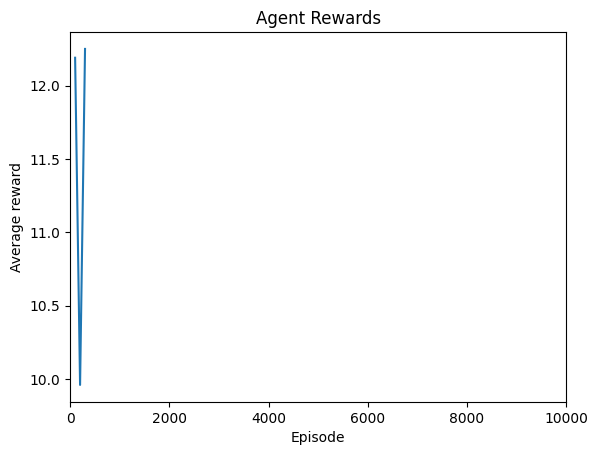

In [11]:
# Rewards
if reward_history[0]:
    plt.plot(reward_history[0], reward_history[1])
    plt.title("Agent Rewards")
    plt.ylabel("Average reward")
    plt.xlabel("Episode")
    plt.ylim()
    plt.xlim(left=0, right=num_episodes)
    plt.show()

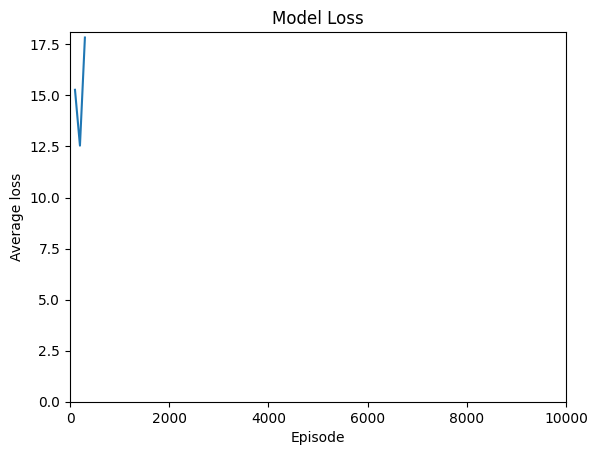

In [12]:
# Loss
if loss_history[0]:
    plt.plot(loss_history[0], loss_history[1])
    plt.title("Model Loss")
    plt.ylabel("Average loss")
    plt.xlabel("Episode")
    plt.ylim(bottom=0)
    plt.xlim(left=0, right=num_episodes)
    plt.show()

In [13]:
env = PacmanEnv(
    grid,
    pacman_sprite=r".\assets\pacman.png",
    render_mode="human",
    fps=7.5,
    ghosts=[ghost],
    tile_size=20,
)
closed = False

while not closed:
    obs = env.reset()
    steps = 0
    while True:
        state = agent._format_state(obs, env.pacman.location())
        x = np.expand_dims(state, 0)
        q_values = agent.q_network(x)[0]
        action = env.best_action(q_values)
        next_obs, reward, done, pacman_location, next_pacman_location, closed = (
            env.step(action, debug=False)
        )
        steps += 1
        print(reward, q_values)
        obs = next_obs
        if done or closed:
            break

env.close()

1 tf.Tensor([60.427814 64.44561  55.184883 64.13482 ], shape=(4,), dtype=float32)
1 tf.Tensor([63.05105  66.47924  57.169064 65.090805], shape=(4,), dtype=float32)
1 tf.Tensor([54.18546  58.42672  50.389866 58.63897 ], shape=(4,), dtype=float32)
1 tf.Tensor([52.265217 56.583797 48.879147 54.44184 ], shape=(4,), dtype=float32)
1 tf.Tensor([39.416737 42.49657  39.567223 44.642426], shape=(4,), dtype=float32)
1 tf.Tensor([37.844738 39.669727 34.72784  46.09953 ], shape=(4,), dtype=float32)
1 tf.Tensor([27.749546 29.605415 19.856314 43.64002 ], shape=(4,), dtype=float32)
1 tf.Tensor([23.059444 24.341074 16.126621 41.946293], shape=(4,), dtype=float32)
1 tf.Tensor([29.84538  30.365139 26.981504 46.513065], shape=(4,), dtype=float32)
1 tf.Tensor([35.218613 35.821903 35.79809  47.190807], shape=(4,), dtype=float32)
1 tf.Tensor([42.495476 47.249878 42.107296 47.90284 ], shape=(4,), dtype=float32)
1 tf.Tensor([44.048237 47.927277 43.741264 47.48389 ], shape=(4,), dtype=float32)
1 tf.Tensor([36.

In [14]:
agent.save_data()